# CNN

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, matthews_corrcoef, f1_score
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### Paths

In [ ]:
gen_path = 'dataset/birdclef-2024/images/'

# Images paths
stft_mel_full_train_images_path = os.path.join(gen_path, 'stft_mel_full_train_images/')
stft_mfcc_full_train_images_path = os.path.join(gen_path, 'stft_mfcc_full_train_images/')

images_path = os.path.join(gen_path, 'train_images/')
normalized_images_path = os.path.join(gen_path, 'normalized_train_images/')
filtered_images_path = os.path.join(gen_path, 'filtered_train_images/')

stft_mel_1mn_path = os.path.join(gen_path, 'stft_mel_1mn/')
stft_mfcc_1mn_path = os.path.join(gen_path, 'stft_mfcc_1mn/')

stft_mel_3mn_path = os.path.join(gen_path, 'stft_mel_3mn/')
stft_mfcc_3mn_path = os.path.join(gen_path, 'stft_mel_3mn/')

stft_mel_5mn_path = os.path.join(gen_path, 'stft_mel_5mn/')
stft_mfcc_5mn_path = os.path.join(gen_path, 'stft_mfcc_5mn/')

stft_mel_50_path = os.path.join(gen_path, 'stft_mel_50/')
stft_mfcc_50_path = os.path.join(gen_path, 'stft_mfcc_50/')

stft_mel_100_path = os.path.join(gen_path, 'stft_mel_100/')
stft_mfcc_100_path = os.path.join(gen_path, 'stft_mfcc_100/')

stft_mel_500_path = os.path.join(gen_path, 'stft_mel_500/')
stft_mfcc_500_path = os.path.join(gen_path, 'stft_mfcc_500/')

# Audio path
audio_path = os.path.join('dataset/birdclef-2024/', 'train_audio/')

### Copy files to train, test and validation

In [3]:
list_audio = {}

# Class and files
for dir in os.listdir(audio_path):
    dir_path = os.path.join(audio_path, dir)
    if os.path.isdir(dir_path):
        for file in os.listdir(dir_path):
            if dir not in list_audio:
                list_audio[dir] = []
            list_audio[dir].append(file)

In [11]:
def split_data(source_dir, base_output_dir, percentage_test=0.2, percentage_val=0.1):
    
    for split in ['train', 'test', 'val']:
        os.makedirs(os.path.join(base_output_dir, split), exist_ok=True)

    class_folders = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for class_folder in class_folders:
        class_path = os.path.join(source_dir, class_folder)
        files = os.listdir(class_path)
        
        random.shuffle(files)

        num_test = int(len(files) * percentage_test)
        num_val = int(len(files) * percentage_val)

        test_files = files[:num_test]
        val_files = files[num_test:num_test + num_val]
        train_files = files[num_test + num_val:]

        # Coping files
        for split, split_files in zip(['train','test', 'val'],[train_files, test_files, val_files]):
            split_class_folder = os.path.join(base_output_dir, split, class_folder)
            os.makedirs(split_class_folder, exist_ok=True)
            for file in split_files:
                shutil.copy(os.path.join(class_path, file), split_class_folder)

In [ ]:
image_paths = [
    images_path,
    normalized_images_path,
    filtered_images_path,

    stft_mel_1mn_path,
    stft_mel_3mn_path,
    stft_mel_5mn_path,
    stft_mel_50_path,
    stft_mel_100_path,
    stft_mel_500_path,

    stft_mfcc_1mn_path,
    stft_mfcc_3mn_path,
    stft_mfcc_5mn_path,
    stft_mfcc_50_path,
    stft_mfcc_100_path,
    stft_mfcc_500_path,
    
    stft_mel_full_train_images_path,
    stft_mfcc_full_train_images_path
]

with tqdm(total=len(image_paths), dynamic_ncols=True) as pbar:
    for path in image_paths:
        pbar.set_description(f'Processing {path.split("/")[-2]}')
        source_dir = os.path.join(path, path.split('/')[-2] + '/')
        output_dir = path
        split_data(source_dir, output_dir)
        pbar.update(1)

Processing stft_mfcc_full_train_images: 100%|██████████| 9/9 [05:13<00:00, 34.87s/it]


# Data setup

In [15]:
def get_class_names(path):
    class_names = []

    for class_name in os.listdir(path):
        class_names.append(class_name)
    
    return class_names

In [16]:
def generator(data_dir, class_names, image_shape=(32,32), batch_size=8, class_mode='categorical', subset='validation', shuffle=False):

    datagen = ImageDataGenerator(rescale = 1./255., samplewise_center=True, samplewise_std_normalization=True)

    generator = datagen.flow_from_directory(
        data_dir,
        target_size=image_shape,
        batch_size=batch_size,
        classes=class_names,
        class_mode=class_mode,
        subset='training',
        shuffle=shuffle
    )

    return generator

### Train paths

In [ ]:
images_path_train = os.path.join(images_path, 'train/')
normalized_train_path = os.path.join(normalized_images_path, 'train/')
filtered_train_path = os.path.join(filtered_images_path, 'train/')

stft_mfcc_1mn_train_path = os.path.join(stft_mfcc_1mn_path, 'train/')
stft_mel_1mn_train_path = os.path.join(stft_mel_1mn_path, 'train/')

stft_mfcc_3mn_train_path = os.path.join(stft_mfcc_3mn_path, 'train/')
stft_mel_3mn_train_path = os.path.join(stft_mel_3mn_path, 'train/')

stft_mfcc_5mn_train_path = os.path.join(stft_mfcc_5mn_path, 'train/')
stft_mel_5mn_train_path = os.path.join(stft_mel_5mn_path, 'train/')

stft_mfcc_50_train_path = os.path.join(stft_mfcc_50_path, 'train/')
stft_mel_50_train_path = os.path.join(stft_mel_50_path, 'train/')

stft_mfcc_100_train_path = os.path.join(stft_mfcc_100_path, 'train/')
stft_mel_100_train_path = os.path.join(stft_mel_100_path, 'train/')

stft_mfcc_500_train_path = os.path.join(stft_mfcc_500_path, 'train/')
stft_mel_500_train_path = os.path.join(stft_mel_500_path, 'train/')

stft_mel_full_train_path = os.path.join(stft_mel_full_train_images_path,'train/')
stft_mfcc_full_train_path = os.path.join(stft_mfcc_full_train_images_path,'train/')

NameError: name 'os' is not defined

### Test paths

In [ ]:
images_path_test = os.path.join(images_path, 'test/')
normalized_test_path = os.path.join(normalized_images_path, 'test/')
filtered_test_path = os.path.join(filtered_images_path, 'test/')

stft_mfcc_1mn_test_path = os.path.join(stft_mfcc_1mn_path, 'test/')
stft_mel_1mn_test_path = os.path.join(stft_mel_1mn_path, 'test/')

stft_mfcc_3mn_test_path = os.path.join(stft_mfcc_3mn_path, 'test/')
stft_mel_3mn_test_path = os.path.join(stft_mel_3mn_path, 'test/')

stft_mfcc_5mn_test_path = os.path.join(stft_mfcc_5mn_path, 'test/')
stft_mel_5mn_test_path = os.path.join(stft_mel_5mn_path, 'test/')

stft_mfcc_50_test_path = os.path.join(stft_mfcc_50_path, 'test/')
stft_mel_50_test_path = os.path.join(stft_mel_50_path, 'test/')

stft_mfcc_100_test_path = os.path.join(stft_mfcc_100_path, 'test/')
stft_mel_100_test_path = os.path.join(stft_mel_100_path, 'test/')

stft_mfcc_500_test_path = os.path.join(stft_mfcc_500_path, 'test/')
stft_mel_500_test_path = os.path.join(stft_mel_500_path, 'test/')

stft_mel_full_test_path = os.path.join(stft_mel_full_train_images_path,'test/')
stft_mfcc_full_test_path = os.path.join(stft_mfcc_full_train_images_path,'test/')

### Val paths

In [ ]:
images_path_val = os.path.join(images_path, 'val/')
normalized_val_path = os.path.join(normalized_images_path, 'val/')
filtered_val_path = os.path.join(filtered_images_path, 'val/')

stft_mfcc_1mn_val_path = os.path.join(stft_mfcc_1mn_path, 'val/')
stft_mel_1mn_val_path = os.path.join(stft_mel_1mn_path, 'val/')

stft_mfcc_3mn_val_path = os.path.join(stft_mfcc_3mn_path, 'val/')
stft_mel_3mn_val_path = os.path.join(stft_mel_3mn_path, 'val/')

stft_mfcc_5mn_val_path = os.path.join(stft_mfcc_5mn_path, 'val/')
stft_mel_5mn_val_path = os.path.join(stft_mel_5mn_path, 'val/')

stft_mfcc_50_val_path = os.path.join(stft_mfcc_50_path, 'val/')
stft_mel_50_val_path = os.path.join(stft_mel_50_path, 'val/')

stft_mfcc_100_val_path = os.path.join(stft_mfcc_100_path, 'val/')
stft_mel_100_val_path = os.path.join(stft_mel_100_path, 'val/')

stft_mfcc_500_val_path = os.path.join(stft_mfcc_500_path, 'val/')
stft_mel_500_val_path = os.path.join(stft_mel_500_path, 'val/')

stft_mel_full_val_path = os.path.join(stft_mel_full_train_images_path,'val/')
stft_mfcc_full_val_path = os.path.join(stft_mfcc_full_train_images_path,'val/')

### Get class names

In [ ]:
class_names_images = get_class_names(images_path_train)
class_names_normalized = get_class_names(normalized_train_path)
class_names_filtered = get_class_names(filtered_train_path)

class_names_mfcc_1mn = get_class_names(stft_mfcc_1mn_train_path)
class_names_mel_1mn = get_class_names(stft_mel_1mn_train_path)

class_names_mfcc_3mn = get_class_names(stft_mfcc_3mn_train_path)
class_names_mel_3mn = get_class_names(stft_mel_3mn_train_path)

class_names_mfcc_5mn = get_class_names(stft_mfcc_5mn_train_path)
class_names_mel_5mn = get_class_names(stft_mel_5mn_train_path)

class_names_mfcc_50 = get_class_names(stft_mfcc_50_train_path)
class_names_mel_50 = get_class_names(stft_mel_50_train_path)

class_names_mfcc_100 = get_class_names(stft_mfcc_100_train_path)
class_names_mel_100 = get_class_names(stft_mel_100_train_path)

class_names_mfcc_500 = get_class_names(stft_mfcc_500_train_path)
class_names_mel_500 = get_class_names(stft_mel_500_train_path)

class_names_stft_mel_full = get_class_names(stft_mel_full_train_path)
class_names_stft_mfcc_full = get_class_names(stft_mfcc_full_train_path)

### Train Generators

In [ ]:
img_shape = (71,71)

train_img = generator(data_dir=images_path_train,image_shape=img_shape, class_names=class_names_images, batch_size=128, shuffle=True)
train_normlized = generator(data_dir=normalized_train_path,image_shape=img_shape, class_names=class_names_normalized, batch_size=128, shuffle=True)
train_filtered = generator(data_dir=filtered_train_path,image_shape=img_shape, class_names=class_names_filtered, batch_size=128, shuffle=True)

train_stft_mfcc_1mn = generator(data_dir=stft_mfcc_1mn_train_path, image_shape=img_shape, class_names=class_names_mfcc_1mn, batch_size=128, shuffle=True)
train_stft_mel_1mn = generator(data_dir=stft_mel_1mn_train_path, image_shape=img_shape, class_names=class_names_mel_1mn, batch_size=128, shuffle=True)

train_stft_mfcc_3mn = generator(data_dir=stft_mfcc_3mn_train_path, image_shape=img_shape, class_names=class_names_mfcc_3mn, batch_size=128, shuffle=True)
train_stft_mel_3mn = generator(data_dir=stft_mel_3mn_train_path, image_shape=img_shape, class_names=class_names_mel_3mn, batch_size=128, shuffle=True)

train_stft_mfcc_5mn = generator(data_dir=stft_mfcc_5mn_train_path, image_shape=img_shape, class_names=class_names_mfcc_5mn, batch_size=128, shuffle=True)
train_stft_mel_5mn = generator(data_dir=stft_mel_5mn_train_path, image_shape=img_shape, class_names=class_names_mel_5mn, batch_size=128, shuffle=True)

train_stft_mfcc_50 = generator(data_dir=stft_mfcc_50_train_path, image_shape=img_shape, class_names=class_names_mfcc_50, batch_size=128, shuffle=True)
train_stft_mel_50 = generator(data_dir=stft_mel_50_train_path, image_shape=img_shape, class_names=class_names_mel_50, batch_size=128, shuffle=True)

train_stft_mfcc_100 = generator(data_dir=stft_mfcc_100_train_path, image_shape=img_shape, class_names=class_names_mfcc_100, batch_size=128, shuffle=True)
train_stft_mel_100 = generator(data_dir=stft_mel_100_train_path, image_shape=img_shape, class_names=class_names_mel_100, batch_size=128, shuffle=True)

train_stft_mfcc_500 = generator(data_dir=stft_mfcc_500_train_path, image_shape=img_shape, class_names=class_names_mfcc_500, batch_size=128, shuffle=True)
train_stft_mel_500 = generator(data_dir=stft_mel_500_train_path, image_shape=img_shape, class_names=class_names_mel_500, batch_size=128, shuffle=True)

train_stft_mel_full = generator(data_dir=stft_mel_full_train_path,image_shape=img_shape, class_names=class_names_stft_mel_full, batch_size=128, shuffle=True)
train_stft_mfcc_full = generator(data_dir=stft_mfcc_full_train_path,image_shape=img_shape, class_names=class_names_stft_mfcc_full, batch_size=128, shuffle=True)

Found 17248 images belonging to 182 classes.
Found 17248 images belonging to 182 classes.
Found 17248 images belonging to 182 classes.
Found 2065 images belonging to 31 classes.
Found 2065 images belonging to 31 classes.
Found 2065 images belonging to 31 classes.
Found 17248 images belonging to 182 classes.
Found 17248 images belonging to 182 classes.


### Test Generators

In [ ]:
test_img = generator(data_dir=images_path_test,image_shape=(71,71), class_names=class_names_images, batch_size=128, shuffle=False)
test_normlized = generator(data_dir=normalized_test_path,image_shape=img_shape, class_names=class_names_normalized, batch_size=128, shuffle=False)
test_filtered = generator(data_dir=filtered_test_path,image_shape=img_shape, class_names=class_names_filtered, batch_size=128, shuffle=False)

test_stft_mfcc_1mn = generator(data_dir=stft_mfcc_1mn_test_path, image_shape=img_shape, class_names=class_names_mfcc_1mn, batch_size=128, shuffle=False)
test_stft_mel_1mn = generator(data_dir=stft_mel_1mn_test_path, image_shape=img_shape, class_names=class_names_mel_1mn, batch_size=128, shuffle=False)

test_stft_mfcc_3mn = generator(data_dir=stft_mfcc_3mn_test_path, image_shape=img_shape, class_names=class_names_mfcc_3mn, batch_size=128, shuffle=False)
test_stft_mel_3mn = generator(data_dir=stft_mel_3mn_test_path, image_shape=img_shape, class_names=class_names_mel_3mn, batch_size=128, shuffle=False)

test_stft_mfcc_5mn = generator(data_dir=stft_mfcc_5mn_test_path, image_shape=img_shape, class_names=class_names_mfcc_5mn, batch_size=128, shuffle=False)
test_stft_mel_5mn = generator(data_dir=stft_mel_5mn_test_path, image_shape=img_shape, class_names=class_names_mel_5mn, batch_size=128, shuffle=False)

test_stft_mfcc_50 = generator(data_dir=stft_mfcc_50_test_path, image_shape=img_shape, class_names=class_names_mfcc_50, batch_size=128, shuffle=False)
test_stft_mel_50 = generator(data_dir=stft_mel_50_test_path, image_shape=img_shape, class_names=class_names_mel_50, batch_size=128, shuffle=False)

test_stft_mfcc_100 = generator(data_dir=stft_mfcc_100_test_path, image_shape=img_shape, class_names=class_names_mfcc_100, batch_size=128, shuffle=False)
test_stft_mel_100 = generator(data_dir=stft_mel_100_test_path, image_shape=img_shape, class_names=class_names_mel_100, batch_size=128, shuffle=False)

test_stft_mfcc_500 = generator(data_dir=stft_mfcc_500_test_path, image_shape=img_shape, class_names=class_names_mfcc_500, batch_size=128, shuffle=False)
test_stft_mel_500 = generator(data_dir=stft_mel_500_test_path, image_shape=img_shape, class_names=class_names_mel_500, batch_size=128, shuffle=False)

test_stft_mel_full = generator(data_dir=stft_mel_full_test_path,image_shape=img_shape, class_names=class_names_stft_mel_full, batch_size=128, shuffle=False)
test_stft_mfcc_full = generator(data_dir=stft_mfcc_full_test_path,image_shape=img_shape, class_names=class_names_stft_mfcc_full, batch_size=128, shuffle=False)

Found 4835 images belonging to 182 classes.
Found 4835 images belonging to 182 classes.
Found 4835 images belonging to 182 classes.
Found 571 images belonging to 31 classes.
Found 571 images belonging to 31 classes.
Found 571 images belonging to 31 classes.
Found 4835 images belonging to 182 classes.
Found 4835 images belonging to 182 classes.


### Val Generators

In [ ]:
val_img = generator(data_dir=images_path_val,image_shape=(71,71), class_names=class_names_images, batch_size=128, shuffle=True)
val_normlized = generator(data_dir=normalized_val_path,image_shape=img_shape, class_names=class_names_normalized, batch_size=128, shuffle=True)
val_filtered = generator(data_dir=filtered_val_path,image_shape=img_shape, class_names=class_names_filtered, batch_size=128, shuffle=True)

val_stft_mfcc_1mn = generator(data_dir=stft_mfcc_1mn_val_path, image_shape=img_shape, class_names=class_names_mfcc_1mn, batch_size=128, shuffle=True)
val_stft_mel_1mn = generator(data_dir=stft_mel_1mn_val_path, image_shape=img_shape, class_names=class_names_mel_1mn, batch_size=128, shuffle=True)

val_stft_mfcc_3mn = generator(data_dir=stft_mfcc_3mn_val_path, image_shape=img_shape, class_names=class_names_mfcc_3mn, batch_size=128, shuffle=True)
val_stft_mel_3mn = generator(data_dir=stft_mel_3mn_val_path, image_shape=img_shape, class_names=class_names_mel_3mn, batch_size=128, shuffle=True)

val_stft_mfcc_5mn = generator(data_dir=stft_mfcc_5mn_val_path, image_shape=img_shape, class_names=class_names_mfcc_5mn, batch_size=128, shuffle=True)
val_stft_mel_5mn = generator(data_dir=stft_mel_5mn_val_path, image_shape=img_shape, class_names=class_names_mel_5mn, batch_size=128, shuffle=True)

val_stft_mfcc_50 = generator(data_dir=stft_mfcc_50_val_path, image_shape=img_shape, class_names=class_names_mfcc_50, batch_size=128, shuffle=True)
val_stft_mel_50 = generator(data_dir=stft_mel_50_val_path, image_shape=img_shape, class_names=class_names_mel_50, batch_size=128, shuffle=True)

val_stft_mfcc_100 = generator(data_dir=stft_mfcc_100_val_path, image_shape=img_shape, class_names=class_names_mfcc_100, batch_size=128, shuffle=True)
val_stft_mel_100 = generator(data_dir=stft_mel_100_val_path, image_shape=img_shape, class_names=class_names_mel_100, batch_size=128, shuffle=True)

val_stft_mfcc_500 = generator(data_dir=stft_mfcc_500_val_path, image_shape=img_shape, class_names=class_names_mfcc_500, batch_size=128, shuffle=True)
val_stft_mel_500 = generator(data_dir=stft_mel_500_val_path, image_shape=img_shape, class_names=class_names_mel_500, batch_size=128, shuffle=True)

val_stft_mel_full = generator(data_dir=stft_mel_full_val_path,image_shape=img_shape, class_names=class_names_stft_mel_full, batch_size=128, shuffle=True)
val_stft_mfcc_full = generator(data_dir=stft_mfcc_full_val_path,image_shape=img_shape, class_names=class_names_stft_mfcc_full, batch_size=128, shuffle=True)

Found 2376 images belonging to 182 classes.
Found 2376 images belonging to 182 classes.
Found 2376 images belonging to 182 classes.
Found 275 images belonging to 31 classes.
Found 275 images belonging to 31 classes.
Found 275 images belonging to 31 classes.
Found 2376 images belonging to 182 classes.
Found 2376 images belonging to 182 classes.


# Convolutional Neural Network (CNN)

In [25]:
def get_model(base_model, hidden_layers, activation, output, output_activation, dropout=None, freeze_base_model=True):
    # freeze layers
    for lys in base_model.layers:
                lys.trainable = not freeze_base_model
    mdl = base_model.output

    for hl in hidden_layers:
        mdl = tf.keras.layers.Dense(hl, activation=activation)(mdl)
    if dropout:
        mdl = tf.keras.layers.Dropout(dropout)(mdl)
    mdl = tf.keras.layers.Dense(output, activation=output_activation)(mdl)
    model = tf.keras.models.Model(base_model.input, mdl)
    return model

### DenseNet

In [ ]:
def densenet(path, learning_rate, epochs , output, validation ,shape=(32,32,3), hidden_layers=[512], activation='relu', output_activation='softmax'):
    
    model_densenet = tf.keras.applications.DenseNet121(input_shape=shape, include_top=False, weights='imagenet', pooling='max')
    model_densenet = get_model(model_densenet, hidden_layers, activation, output, output_activation, freeze_base_model=False)
    
    model_densenet.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6, min_delta=1e-3)

    history = model_densenet.fit(path, epochs=epochs, validation_data=validation, callbacks=[early_stopping,reduce_lr])

    return model_densenet, history

### Xception

In [ ]:
def xception(path, learning_rate, epochs , output, validation ,shape=(32,32,3), hidden_layers=[512], activation='relu', output_activation='softmax'):
    
    model_xception = tf.keras.applications.Xception(input_shape=shape, include_top=False, weights='imagenet', pooling='max')
    model_xception = get_model(model_xception, hidden_layers, activation, output, output_activation, freeze_base_model=False)
    
    model_xception.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6, min_delta=1e-3)

    history = model_xception.fit(path, epochs=epochs, validation_data=validation, callbacks=[early_stopping,reduce_lr])

    return model_xception, history

### VGG19

In [2]:
def vgg19(path, learning_rate, epochs , output, validation ,shape=(32,32,3), hidden_layers=[512], activation='relu', output_activation='softmax'):
    
    model_VGG19 = tf.keras.applications.VGG19(input_shape=shape, include_top=False, weights='imagenet', pooling='max')
    model_VGG19 = get_model(model_VGG19, hidden_layers, activation, output, output_activation, freeze_base_model=False)
    
    model_VGG19.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', 'mse'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, min_lr=1e-6, min_delta=1e-3)

    history = model_VGG19.fit(path, epochs=epochs, validation_data=validation, callbacks=[early_stopping,reduce_lr])

    return model_VGG19, history

## Train

In [ ]:
def train(path, learning_rate, epochs , output, validation ,shape=(32,32, 3), hidden_layers=[512], activation='relu', output_activation='softmax'):
    densenet_model, history_densenet = densenet(path=path, learning_rate=learning_rate, epochs=epochs, output=output,
                                                    validation=validation,shape=shape,
                                                    hidden_layers=hidden_layers, activation=activation, output_activation=output_activation)

    xception_model, history_xception = xception(path=path, learning_rate=learning_rate, epochs=epochs, output=output,
                                                    validation=validation,shape=shape,
                                                    hidden_layers=hidden_layers, activation=activation, output_activation=output_activation)

    vgg19_model, history_vgg19 = vgg19(path=path, learning_rate=learning_rate, epochs=epochs, output=output,
                                                    validation=validation,shape=shape,
                                                    hidden_layers=hidden_layers, activation=activation, output_activation=output_activation)
    
    return [densenet_model, history_densenet], [xception_model, history_xception], [vgg19_model, history_vgg19]

### Simple MFCC Images

In [ ]:
simple_mfcc_densenet, simple_mfcc_xception, simple_mfcc_vgg19 = train(path=train_img, learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=val_img,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

### Normalized Images

In [ ]:
normalized_densenet, normalized_xception, normalized_vgg19 = train(path=train_normlized, learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=normalized_val_path,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

### Filtered Images

In [ ]:
filtered_densenet, filtered_xception, filtered_vgg19 = train(path=train_filtered, learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=filtered_val_path,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

In [ ]:
stft_mfcc_1mn_densenet, stft_mfcc_1mn_xception, stft_mfcc_1mn_vgg19 = train(path=train_stft_mfcc_1mn , learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                                    validation=stft_mfcc_1mn_val_path ,shape=(img_shape[0], img_shape[1], 3),
                                                                                    hidden_layers=[512], activation='relu', output_activation='softmax')

### STFT Mel and MFCC 1 minute Images

In [ ]:
stft_mel_1mn_densenet, stft_mel_1mn_xception, stft_mel_1mn_vgg19 = train(path=train_stft_mel_1mn , learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=stft_mel_1mn_val_path,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

In [ ]:
stft_mfcc_3mn_densenet, stft_mfcc_3mn_xception, stft_mfcc_3mn_vgg19 = train(path=train_stft_mfcc_3mn , learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=stft_mfcc_3mn_val_path,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

### STFT Mel and MFCC 3 minute Images

In [ ]:
stft_mel_3mn_densenet, stft_mel_3mn_xception, stft_mel_3mn_vgg19 = train(path=train_stft_mel_3mn, learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=stft_mel_3mn_val_path,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

In [ ]:
stft_mfcc_5mn_densenet, stft_mfcc_5mn_xception, stft_mfcc_5mn_vgg19 = train(path=train_stft_mfcc_5mn, learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=stft_mfcc_5mn_val_path,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

### STFT Mel and MFCC 5 minute Images

In [ ]:
stft_mel_5mn_densenet, stft_mel_5mn_xception, stft_mel_5mn_vgg19 = train(path=train_stft_mel_5mn, learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=stft_mel_5mn_val_path,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

In [ ]:
stft_mfcc_50_densenet, stft_mfcc_50_xception, stft_mfcc_50_vgg19 = train(path=train_stft_mfcc_50, learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=stft_mfcc_50_val_path,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

### STFT Mel and MFCC: Groups with 50 &le; Images &le; 99

In [ ]:
stft_mel_50_densenet, stft_mel_50_xception, stft_mel_50_vgg19 = train(path=train_stft_mel_50, learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=stft_mel_50_val_path,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

In [ ]:
stft_mfcc_100_densenet, stft_mfcc_100_xception, stft_mfcc_100_vgg19 = train(path=train_stft_mfcc_100, learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=stft_mfcc_100_val_path,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

### STFT Mel and MFCC: Groups with 100 &le; Images < 300

In [ ]:
stft_mel_100_densenet, stft_mel_100_xception, stft_mel_100_vgg19 = train(path=train_stft_mel_100 , learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=stft_mel_100_val_path,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

In [ ]:
stft_mfcc_500_densenet, stft_mfcc_500_xception, stft_mfcc_500_vgg19 = train(path=train_stft_mfcc_500 , learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=stft_mfcc_500_val_path,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

### STFT Mel and MFCC: Groups with 300 &le; Images &le; 500

In [ ]:
stft_mel_500_densenet, stft_mel_500_xception, stft_mel_500_vgg19 = train(path=train_stft_mel_500, learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=stft_mel_500_val_path,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

### MFCC and Mel: Full Images 

In [ ]:
stft_mel_full_densenet, stft_mel_full_xception, stft_mel_full_vgg19 = train(path=train_stft_mel_full, learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=stft_mel_full_val_path ,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

In [ ]:
stft_mfcc_full_densenet, stft_mfcc_full_xception, stft_mfcc_full_vgg19 = train(path=train_stft_mfcc_full, learning_rate=0.001, epochs=50, output=len(class_names_images),
                                                                        validation=stft_mfcc_full_val_path,shape=(img_shape[0], img_shape[1], 3),
                                                                        hidden_layers=[512], activation='relu', output_activation='softmax')

### Save results

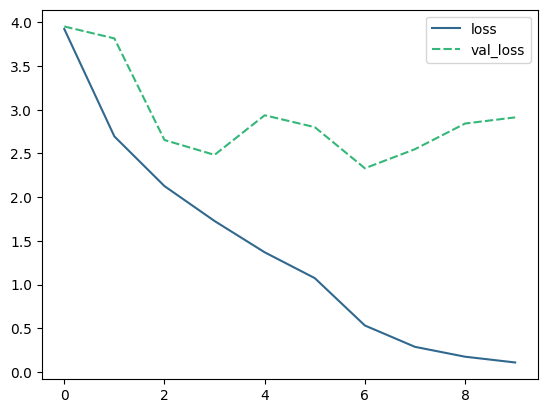

In [129]:
hist = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
sns.lineplot(hist, palette='viridis')
plt.savefig('image_mfcc_train_densnet', bbox_inches='tight', pad_inches=0, transparent=True)

In [97]:
pd.DataFrame(history.history).to_csv('hist_obj_stft_mel.csv')

In [ ]:
pd.DataFrame(hist).to_csv('hist_img_mfcc_train_densnet.csv', index=False)


In [ ]:
model_densenet.save('img_mfcc_densenet.h5')


In [ ]:
model_densenet_stft.save('stft_mel_full.h5') # 53.07 -> 182 clases, 35.92 F1 Score

In [ ]:
model_xception_stft.save('stft_mel_xception_full.h5') # 51.09 -> 182 clases, 32.34 F1 Score

# Metrics

In [77]:
def pred_and_tests(model, test_gen):
    y_pred = model.predict(test_gen)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = test_gen.classes

    return y_pred, y_test

### F1 Score

In [103]:
print(test_stft_mel_full[0][1])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [132]:
for i in range(len(test_stft_mel_full)):
    if i == 0:
        labels = test_stft_mel_full[i][1]
    else:
        labels = np.concatenate([labels, test_stft_mel_full[i][1]])

In [133]:
from sklearn.metrics import f1_score, classification_report

# Obtener las predicciones del modelo en el conjunto de validación
y_pred = model_xception_stft.predict(test_stft_mel_full)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convierte las predicciones a clases

# Obtener las etiquetas verdaderas
y_true = np.argmax(labels, axis=1)

# Calcular el F1 score (macro, micro o weighted según lo que necesites)
f1 = f1_score(y_true, y_pred_classes, average='macro')
print(f'F1 Score (weighted): {f1:.4f}')

# También puedes imprimir un informe de clasificación completo
print(classification_report(y_true, y_pred_classes, target_names=test_stft_mel_full.class_indices.keys()))

38/38 [==============================] - 10s 267ms/step
F1 Score (weighted): 0.3234
              precision    recall  f1-score   support

      asbfly       0.09      0.10      0.09        21
     ashdro1       0.15      0.19      0.17        21
     ashpri1       0.43      0.32      0.36        19
     ashwoo2       0.44      0.44      0.44         9
     asikoe2       0.63      0.65      0.64        55
     asiope1       0.00      0.00      0.00         1
     aspfly1       0.00      0.00      0.00         5
     aspswi1       0.00      0.00      0.00         5
     barfly1       0.00      0.00      0.00         4
      barswa       0.54      0.52      0.53       100
      bcnher       0.62      0.64      0.63       100
     bkcbul1       0.50      0.25      0.33         4
     bkrfla1       0.36      0.80      0.50         5
     bkskit1       0.76      0.77      0.77        53
      bkwsti       0.71      0.75      0.73       100
     bladro1       0.14      0.12      0.13        

c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CICESE\miniforge3\envs\sergio-gpu\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

In [113]:
y_test = y_true
print(y_test)

[ 71  39 106 ...  39  57  20]
